In [1]:

import matplotlib.pyplot as plt
import numpy as np
import xlrd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch
from statsmodels.stats.diagnostic import het_arch
from arch import arch_model



list_of_period = [5,10,15,20,25,30]
list_of_k = [1,1.5,2]
period = 20
k = 2

# Read the data from the Excel file
xls_file = '/home/vishi/bolinger/cumul_ohlc.xls'
xls = xlrd.open_workbook(xls_file)
sheet = xls.sheet_by_index(0)
# the sheet is like this 
# DateTime	open	high	low	close
# 20241231~09:16:00	2355950	2356430	2354005	2355135

df = pd.read_excel(xls_file, sheet_name=0, usecols="A:E", header=0)
# Convert the DateTime column to datetime format
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y%m%d~%H:%M:%S')

# # write the data to a csv file
# df.to_csv('/home/vishi/bolinger/cumul_ohlc.csv', index=False)


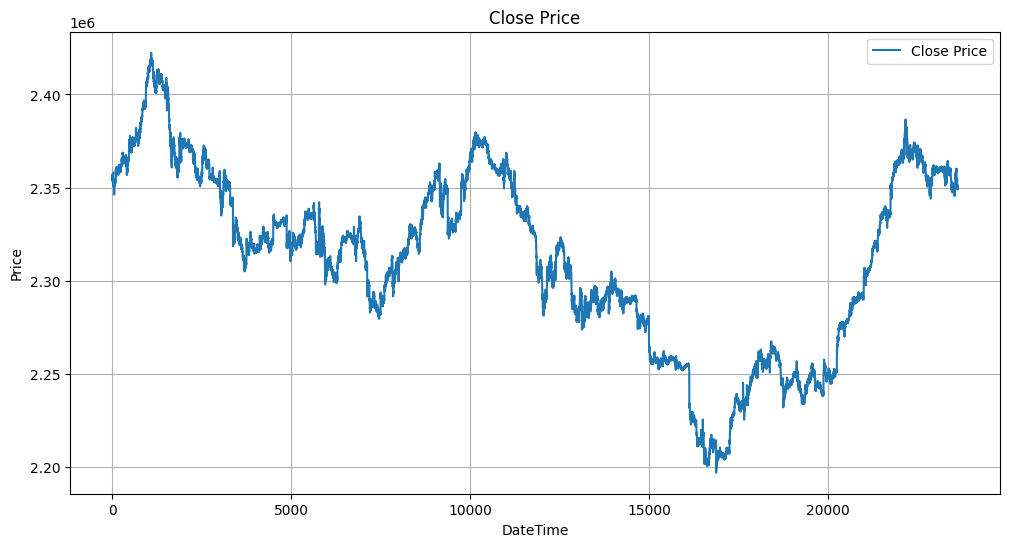

In [2]:
# plot the closing price for 1st 500 minutes
# df = df.iloc[:500]
plt.figure(figsize=(12, 6))
plt.plot(df['close'], label='Close Price')
plt.title('Close Price')
plt.xlabel('DateTime')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [3]:
result_closing = adfuller(df['close'])
print('ADF Statistic:', result_closing[0])
print('p-value:', result_closing[1])

ADF Statistic: -1.3908044562755402
p-value: 0.5866765519455941


In [4]:
# now create a new column with the difference of the closing price
df['close_diff'] = df['close'].diff()
# # write the data to a new csv file
# df.to_csv('/home/vishi/bolinger/cumul_ohlc_diff.csv', index=False)

In [171]:
# new column with the percent of difference of the closing price
df['close_diff_percent'] = df['close'].pct_change()* 10000
# add moving average of the closing price window = 20
df['close_moving_avg'] = df['close'].rolling(window=period).mean()
df["std"] = df['close'].rolling(window=period).std()
df["upper_bb"] = df['close_moving_avg'] + k * df["std"]
df["lower_bb"] = df['close_moving_avg'] - k * df["std"]
# # write the data to a new csv file
df.to_csv('/home/vishi/bolinger/cumul_ohlc_diff_percent.csv', index=False)

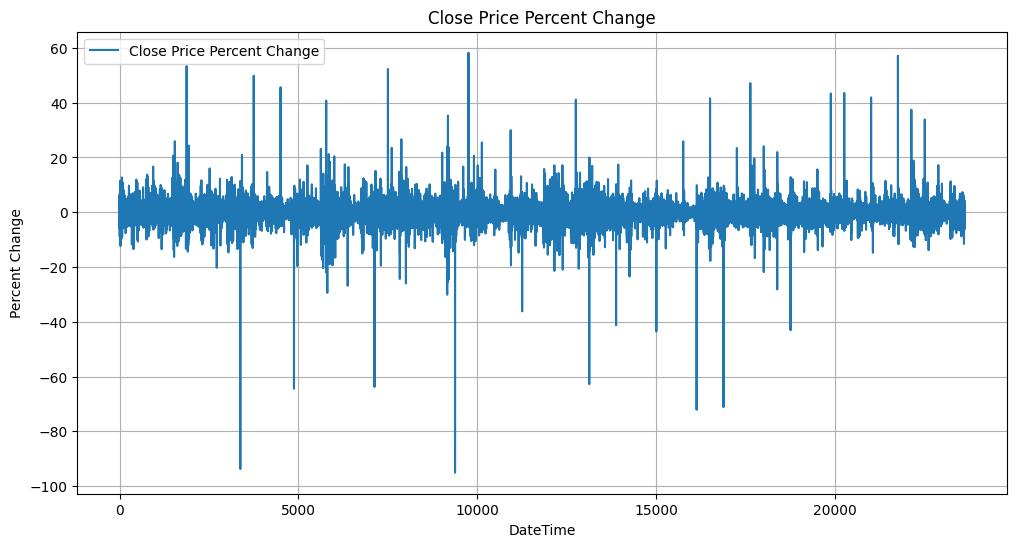

In [6]:
# plot_returns
plt.figure(figsize=(12, 6))
plt.plot(df['close_diff_percent'], label='Close Price Percent Change')
plt.title('Close Price Percent Change')
plt.xlabel('DateTime')
plt.ylabel('Percent Change')
plt.legend()
plt.grid()
plt.show()


In [7]:
result_of_adfuller_of_diff_percent = adfuller(df['close_diff_percent'].dropna())
print('ADF Statistic:', result_of_adfuller_of_diff_percent[0])
print('p-value:', result_of_adfuller_of_diff_percent[1])


ADF Statistic: -29.040516580909927
p-value: 0.0


In [8]:
lying_box_result = acorr_ljungbox(df['close_diff_percent'].dropna(), lags=[10, 20], return_df=True)
print(lying_box_result)

      lb_stat     lb_pvalue
10  83.629521  9.720924e-14
20  97.452412  3.588658e-12


<Figure size 1200x600 with 0 Axes>

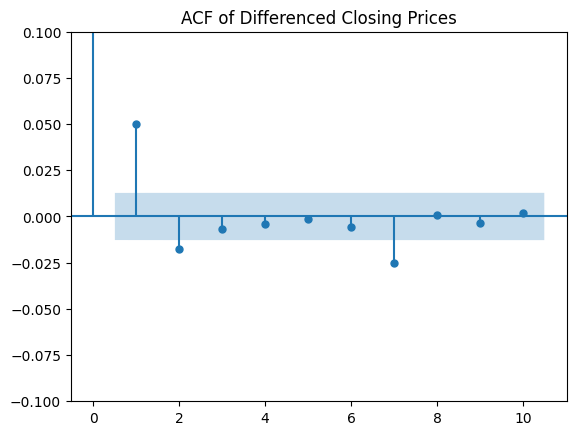

<Figure size 1200x600 with 0 Axes>

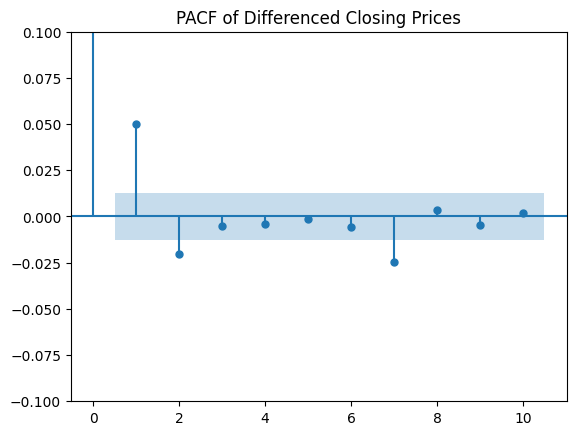

In [9]:
# remove the lag 0 start from lag 1
plt.figure(figsize=(12, 6))
plot_acf(np.array(df["close_diff_percent"].dropna()), lags=10)
# i want yscale to be between 106-3 to -10^-3
plt.ylim(-0.1, 0.1)
plt.title('ACF of Differenced Closing Prices')
plt.show()
plt.figure(figsize=(12, 6))
plot_pacf(np.array(df["close_diff_percent"].dropna()), lags=10)
plt.ylim(-0.1, 0.1)

plt.title('PACF of Differenced Closing Prices')
plt.show()



In [10]:

# df.to_csv('/home/vishi/bolinger/cumul_ohlc_diff_percent_indexed.csv', index=True)
model_1_1 = ARIMA(df['close_diff_percent'].dropna(), order=(1, 0, 1))
# fit the model
model_1_1_fit = model_1_1.fit()
# print the summary
print(model_1_1_fit.summary())

/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:     close_diff_percent   No. Observations:                23624
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -65421.351
Date:                Thu, 22 May 2025   AIC                         130850.701
Time:                        10:32:36   BIC                         130882.981
Sample:                             0   HQIC                        130861.178
                              - 23624                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.027     -0.010      0.992      -0.052       0.052
ar.L1         -0.2615      0.081     -3.219      0.001      -0.421      -0.102
ma.L1          0.3126      0.081      3.867      0.0

In [11]:
# order = (2, 0, 2)
model_2_2 = ARIMA(df['close_diff_percent'].dropna(), order=(2, 0, 2))
# fit the model
model_2_2_fit = model_2_2.fit()
# print the summary
print(model_2_2_fit.summary())

/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:     close_diff_percent   No. Observations:                23624
Model:                 ARIMA(2, 0, 2)   Log Likelihood              -65418.424
Date:                Thu, 22 May 2025   AIC                         130848.849
Time:                        10:33:00   BIC                         130897.269
Sample:                             0   HQIC                        130864.563
                              - 23624                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.025     -0.010      0.992      -0.050       0.049
ar.L1          0.6929      0.108      6.401      0.000       0.481       0.905
ar.L2          0.0928      0.094      0.986      0.3

In [12]:
# order = (1, 0, 0)
model_1_0 = ARIMA(df['close_diff_percent'].dropna(), order=(1, 0, 0))
# fit the model
model_1_0_fit = model_1_0.fit()
# print the summary
print(model_1_0_fit.summary())



# order = (0, 0, 1)
model_0_1 = ARIMA(df['close_diff_percent'].dropna(), order=(0, 0, 1))
# fit the model
model_0_1_fit = model_0_1.fit()
# print the summary
print(model_0_1_fit.summary())

/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:     close_diff_percent   No. Observations:                23624
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -65425.101
Date:                Thu, 22 May 2025   AIC                         130856.202
Time:                        10:33:03   BIC                         130880.412
Sample:                             0   HQIC                        130864.059
                              - 23624                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.027     -0.010      0.992      -0.053       0.052
ar.L1          0.0498      0.004     13.182      0.000       0.042       0.057
sigma2        14.8946      0.023    640.996      0.0

/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:     close_diff_percent   No. Observations:                23624
Model:                 ARIMA(0, 0, 1)   Log Likelihood              -65423.973
Date:                Thu, 22 May 2025   AIC                         130853.946
Time:                        10:33:05   BIC                         130878.156
Sample:                             0   HQIC                        130861.803
                              - 23624                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.027     -0.010      0.992      -0.053       0.052
ma.L1          0.0517      0.004     13.478      0.000       0.044       0.059
sigma2        14.8919      0.023    640.874      0.0

In [15]:
warnings.simplefilter('ignore', ConvergenceWarning)
best_model = ARIMA(df['close_diff_percent'].dropna(), order=(0, 0, 1))
# fit the model
best_model_fit = best_model.fit()
# print the summary
# print(best_model_fit.summary())
# plot the residuals
# plt.figure(figsize=(12, 6))
# plt.plot(best_model_fit.resid, label='Residuals')
# plt.title('Residuals of Best Model')
# plt.xlabel('DateTime')
# plt.ylabel('Residuals')
# plt.legend()
# plt.grid()
# plt.show()


/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [98]:
best_model_fit.maparams

array([0.05167559])

In [84]:
forecast = best_model_fit.forecast(steps = 6)
# # properties of the forecast
# type(forecast)
# type(forecast.values)
forecast.values#

# len(df['close_diff_percent'].dropna())

/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


array([ 0.07464399, -0.00026378, -0.00026378, -0.00026378, -0.00026378,
       -0.00026378])

In [28]:

residuals_from_best_model = best_model_fit.resid

arch_test = het_arch(residuals_from_best_model)
print('ARCH Test Statistic:', arch_test[0])
print('ARCH Test p-value:', arch_test[1])


ARCH Test Statistic: 37.583450274318935
ARCH Test p-value: 4.4838272285570176e-05


In [30]:

# Fit the GARCH model
garch_model = arch_model(residuals_from_best_model, vol='Garch', p=1, q=1)
garch_model_fit = garch_model.fit(disp="off")
# print(garch_model_fit.summary())


In [184]:
forecast = garch_model_fit.forecast(horizon=20)
# Print the forecasted volatility
print("Forecasted Volatility:")
# print(forecast.variance)
# type(forecast.variance)
forecast.variance.values[-1]

Forecasted Volatility:


array([10.7051518 , 13.7280155 , 15.71859934, 17.02941729, 17.89260309,
       18.46101897, 18.8353261 , 19.08181083, 19.24412331, 19.35100759,
       19.42139188, 19.46774058, 19.49826164, 19.51836004, 19.53159502,
       19.54031038, 19.54604952, 19.54982881, 19.5523175 , 19.55395632])

In [185]:
for i in range(1,3):
    for j in range(0,3):
        # Fit the GARCH model
        garch_model_dummy = arch_model(residuals_from_best_model, vol='Garch', p=i, q=j)
        garch_model_fit_dummy = garch_model_dummy.fit(disp="off")
        print(f'GARCH({i},{j}) Model Summary:')
        print(garch_model_fit_dummy.summary())
        print('\n')

GARCH(1,0) Model Summary:
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -64497.2
Distribution:                  Normal   AIC:                           129000.
Method:            Maximum Likelihood   BIC:                           129025.
                                        No. Observations:                23624
Date:                Fri, May 23 2025   Df Residuals:                    23623
Time:                        11:08:58   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0104  5.174e-02   

In [186]:
def bolinger_bands_from_arima_garch(arima_model_fit, garch_model_fit, steps = 375, k = 2):
    arima_forecast = arima_model_fit.forecast(steps=steps)
    arima_forecast = arima_forecast.values
    garch_forecast = garch_model_fit.forecast(horizon=steps)
    std_dev = np.sqrt(garch_forecast.variance.values[-1])
    upper_band = arima_forecast + k * std_dev
    lower_band = arima_forecast - k * std_dev
    # convert it into a df of midband, upper band, lower band
    df_bolinger = pd.DataFrame({'midband': arima_forecast,
                                'upper_band': upper_band,
                                'lower_band': lower_band})
    return df_bolinger


In [83]:
df_updated = df.loc['2024-12-31' : '2025-01-31 23:59']
# df_updated = df_updated.set_index('DateTime')
# df_updated = df_updated.drop(columns=['open', 'high', 'low', 'close_diff', 'close_diff_percent'])
# save df_updated to a csv file
df_updated.to_csv('/home/vishi/bolinger/cumul_ohlc_updated.csv', index=True)


In [89]:
def train_and_predict_bollinger_using_garch_and_arima(df, steps=375, k = 2, startdate = "2024-12-31", end_date = "2025-01-31", 
                                                      order_arima=(0, 0, 1), order_garch=(1, 1)):
    # seperate the data and collect those between startdate and enddate
    df_updated = df.loc[startdate : end_date]

    arima_model = ARIMA(df_updated['close_diff_percent'].dropna(), order=order_arima)
    arima_model_fit = arima_model.fit()
    garch_model = arch_model(df_updated['close_diff_percent'].dropna(), vol='Garch', p=order_garch[0], q=order_garch[1])
    garch_model_fit = garch_model.fit(disp="off")

    df_forecast = bolinger_bands_from_arima_garch(arima_model_fit, garch_model_fit, steps=steps, k=k)
    # write the df_forecast to a csv file
    df_forecast.to_csv('/home/vishi/bolinger/temp_forecast.csv', index=True)
    return df_forecast

df_forecast = train_and_predict_bollinger_using_garch_and_arima(df, steps=375, k = 2, startdate = "2024-12-31", end_date = "2025-01-31")

    

/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index begin

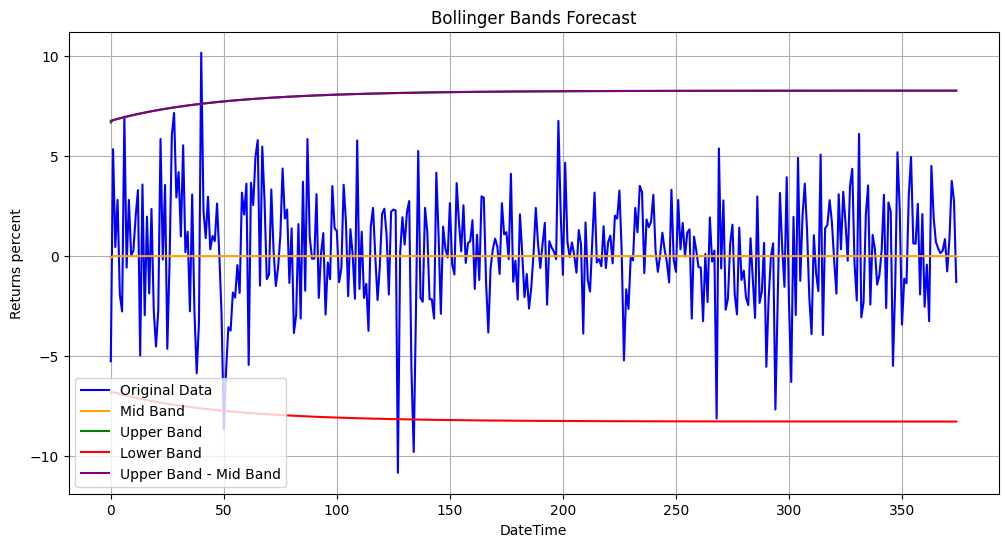

In [96]:
# plot the forecast
plt.figure(figsize=(12, 6))
# plot the original data returns parcent on day 2025-01-31
temp_1 = np.array(df['close_diff_percent'].loc['2025-01-31' : '2025-02-01 00:00'])
plt.plot(temp_1 , label='Original Data', color='blue')
plt.plot(df_forecast['midband'], label='Mid Band', color='orange')
plt.plot(df_forecast['upper_band'], label='Upper Band', color='green')
plt.plot(df_forecast['lower_band'], label='Lower Band', color='red')
plt.plot(df_forecast['upper_band'] - df_forecast['midband'], label='Upper Band - Mid Band', color='purple')
plt.title('Bollinger Bands Forecast')
plt.xlabel('DateTime')
plt.ylabel('Returns percent')
plt.legend()
plt.grid()

In [94]:

df_forecast_2 = train_and_predict_bollinger_using_garch_and_arima(df, steps=375, k = 2, startdate = "2024-12-31", end_date = "2025-02-01")


/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index begin

In [ ]:
upper_band_1 = df_forecast['upper_band'].values
upper_band_2 = df_forecast_2['upper_band'].values
lower_band_1 = df_forecast['lower_band'].values
lower_band_2 = df_forecast_2['lower_band'].values
midband_1 = df_forecast['midband'].values
midband_2 = df_forecast_2['midband'].values

upper_band = np.concatenate((upper_band_1, upper_band_2))
lower_band = np.concatenate((lower_band_1, lower_band_2))
midband = np.concatenate((midband_1, midband_2))


In [ ]:


def Dataset_XLS_To_CSV (path:str, Filename:str, col:int)->bool:
    '''
        Takes the path of an xls file and creates a csv file with its name as Filename.csv \\
        With the csv file containing columns 1 to "col". 
        **********
        #### INPUT
        path - a string of the path to the xls file \\
        Filename - the filename of the resulting csv file, to be saved as \\
        col - a int, where only upto column number "col" is copied 
        **********        
        #### OUTPUT
        boolean value - True => success, False => could not do the operation
    '''

    try :
        # Trying to read the xls file
        data = pd.read_excel(path,engine='xlrd')

        # Saving upto column number "col"
        required_data = data.iloc[:,:col]

        # Saving the data to a csv file
        required_data.to_csv(f"{Filename}.csv", index=False)

        return True
    
    except FileNotFoundError:
        print(f"Error: File at path '{path}' does not exist.")
        return False
    except ValueError as e:
        print(f"Error: {e}")
        return False
    except Exception as e:
        print(f"Exception: {e}")
        return False
   
   
def get_avg_std(prices:np.ndarray,period:int)->tuple:
    '''
        Takes a numpy array of prices and gives the moving average 
        and std deviation of the prices \\
        **********
        #### INPUT
        prices - a numpy array of prices \\
        period - a int, the period for which the moving 
                average and std deviation is to be calculated
        **********
        #### OUTPUT
        tuple - a tuple of the moving average and std deviation
        of the prices
                '''
    avg = np.zeros(len(prices))
    std = np.zeros(len(prices))
    for i in range(period, len(prices)+1):
        avg[i] = np.mean(prices[i-period:i])
        std[i] = np.std(prices[i-period:i])
    return avg, std
    
def construct_upper_lower_bands(prices:np.ndarray, moving_avg:np.ndarray, moving_std:np.ndarray, period:int)->tuple:
    '''
        Takes a numpy array of prices and gives the upper and lower bands \\
        **********
        #### INPUT
        prices - a numpy array of prices \\
        moving_avg - a numpy array of moving averages \\
        moving_std - a numpy array of std deviations \\
        period - a int, the period for which the moving 
                average and std deviation is to be calculated
        **********
        #### OUTPUT
        tuple - a tuple of the upper and lower bands
    '''
    upper_band = np.zeros(len(prices))
    lower_band = np.zeros(len(prices))
    for i in range(period, len(prices)+1):
        upper_band[i] = moving_avg[i] + 2*moving_std[i]
        lower_band[i] = moving_avg[i] - 2*moving_std[i]
    return upper_band, lower_band
    

In [168]:
# pick the closing prices from the df of date 2025-02-01

closing_prices = np.array(df['close'].loc['2025-01-31' : '2025-02-01 00:00'])
avg, std = get_avg_std(closing_prices, 20)
upper_band, lower_band = construct_upper_lower_bands(closing_prices, avg, std, 20)



In [169]:
std.shape

(375,)

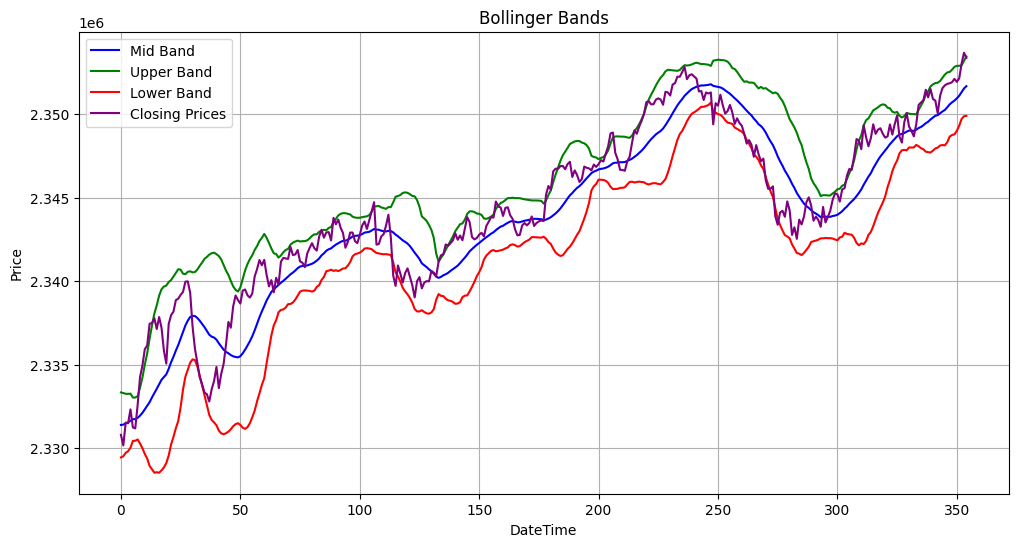

355

In [170]:
plt.figure(figsize=(12, 6))
plt.plot(avg[20:], label='Mid Band', color='blue')
plt.plot(upper_band[20:], label='Upper Band', color='green')
plt.plot(lower_band[20:], label='Lower Band', color='red')
plt.plot(closing_prices[20:], label='Closing Prices', color='purple')
plt.title('Bollinger Bands')
plt.xlabel('DateTime')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()
len(closing_prices[20:])

In [196]:
def func_of_arima(ma_param, residue, mean =0):
    return mean + residue * ma_param

def func_of_garch(omega, alpha, beta, prev_volatility, prev_residual):
    return np.sqrt(omega + alpha * prev_residual ** 2 + beta * prev_volatility**2)

def forecast_returns_percent(df, steps=375, k = 2, startdate = "2024-12-31", end_date = "2025-02-01",
                            order_arima=(0, 0, 1), order_garch=(1, 1)):
    df_filtered = df.loc[startdate : end_date]
    df_prediction = df.loc[ df.index > end_date] 

    arima_model = ARIMA(df_filtered['close_diff_percent'].dropna(), order=order_arima)
    arima_model_fit = arima_model.fit()
    residual_np = np.array(arima_model_fit.resid)



    garch_model = arch_model(residual_np, vol='Garch',mean = "zero" ,p = order_garch[0], q = order_garch[1])
    garch_model_fit = garch_model.fit(disp="off")
    
    
    ma_param = arima_model_fit.maparams[0]
    
    prediction_of_arima = []
    residual_of_prediction = [] 
    
    prediction_of_arima.append(func_of_arima(ma_param, residual_np[-1]))
    residual_of_prediction.append(df_prediction["close_diff_percent"][0] - prediction_of_arima[-1])
    
    for i in range(1, steps):
        prediction_of_arima.append(func_of_arima(ma_param, residual_of_prediction[-1]))
        residual_of_prediction.append(df_prediction["close_diff_percent"][i] - prediction_of_arima[-1])

    garch_fit_params = garch_model_fit.params
    omega = garch_fit_params['omega']
    alpha = garch_fit_params['alpha[1]']
    beta = garch_fit_params['beta[1]']

    vol_garch = garch_model_fit.conditional_volatility

    volatility_prediction_of_garch = []

    volatility_prediction_of_garch.append(func_of_garch(omega, alpha, beta, vol_garch[-1], residual_np[-1]))
    for i in range(1, steps):
        volatility_prediction_of_garch.append(func_of_garch(omega, alpha, beta, volatility_prediction_of_garch[-1], residual_of_prediction[i-1]))
    # save the prediction of garch to a csv file
    np.save('/home/vishi/bolinger/temp_garch_prediction.csv', volatility_prediction_of_garch)
    
    
    return arima_model_fit, garch_model_fit, prediction_of_arima, residual_of_prediction, volatility_prediction_of_garch




/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index begin

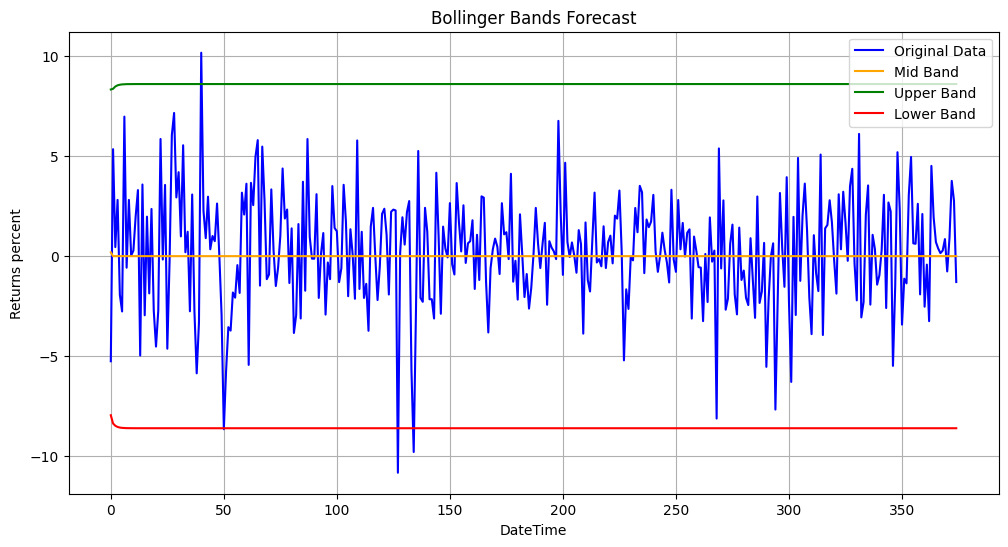

In [ ]:
def forecast_returns_percent_inbuilt(df, steps=375, k = 2, startdate = "2024-12-31", end_date = "2025-02-01",
                                     order_arima=(0, 0, 1), order_garch=(1, 1)):
    df_filtered = df.loc[startdate : end_date]
    df_prediction = df.loc[ df.index > end_date]

    arima_model = ARIMA(df_filtered['close_diff_percent'].dropna(), order=order_arima)
    arima_model_fit = arima_model.fit()

    residual_np = np.array(arima_model_fit.resid)

    garch_model = arch_model(residual_np, vol='Garch',mean = "zero" ,p = order_garch[0], q = order_garch[1])
    garch_model_fit = garch_model.fit(disp="off")
    
    
    ma_param = arima_model_fit.maparams[0]
    
    prediction_of_arima = []
    residual_of_prediction = [] 
    
    prediction_of_arima.append(func_of_arima(ma_param, residual_np[-1]))
    residual_of_prediction.append(df_prediction["close_diff_percent"][0] - prediction_of_arima[-1])
    
    for i in range(1, steps):
        prediction_of_arima.append(func_of_arima(ma_param, residual_of_prediction[-1]))
        residual_of_prediction.append(df_prediction["close_diff_percent"][i] - prediction_of_arima[-1])
    garch_fit_params = garch_model_fit.params
    omega = garch_fit_params['omega']
    alpha = garch_fit_params['alpha[1]']
    beta = garch_fit_params['beta[1]']

    vol_garch = garch_model_fit.conditional_volatility
    volatility_prediction_of_garch = []
    volatility_prediction_of_garch.append(func_of_garch(omega, alpha, beta, vol_garch[-1], residual_np[-1]))
    for i in range(1, steps):
        volatility_prediction_of_garch.append(func_of_garch(omega, alpha, beta, volatility_prediction_of_garch[-1], residual_of_prediction[i-1]))
    # convert the prediction of arima and garch into a numpy array
    prediction_of_arima = np.array(prediction_of_arima)
    volatility_prediction_of_garch = np.array(volatility_prediction_of_garch)
    
    upper_band = prediction_of_arima + k * volatility_prediction_of_garch
    lower_band = prediction_of_arima - k * volatility_prediction_of_garch
    
upper_band_404 , lower_band_404 , arima_forecast_404 = forecast_returns_percent_inbuilt(df, steps=375, k = 2, startdate = "2024-12-31", end_date = "2025-02-01")
# plot the forecast
plt.figure(figsize=(12, 6))
# plot the original data returns parcent on day 2025-01-31
temp_1 = np.array(df['close_diff_percent'].loc['2025-01-31' : '2025-02-01 00:00'])
plt.plot(temp_1 , label='Original Data', color='blue')
plt.plot(arima_forecast_404, label='Mid Band', color='orange')
plt.plot(upper_band_404, label='Upper Band', color='green')
plt.plot(lower_band_404, label='Lower Band', color='red')
# plt.plot(upper_band_404 - arima_forecast_404, label='Upper Band - Mid Band', color='purple')
plt.title('Bollinger Bands Forecast')
plt.xlabel('DateTime')
plt.ylabel('Returns percent')
plt.legend()
plt.grid()
plt.show()



/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/tmp/ipykernel_416832/2160814407.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Da

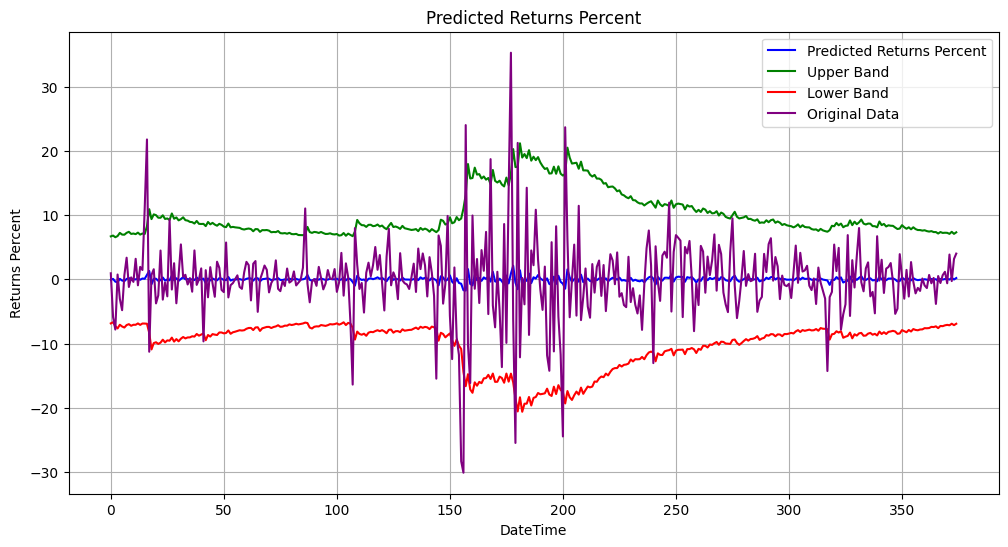

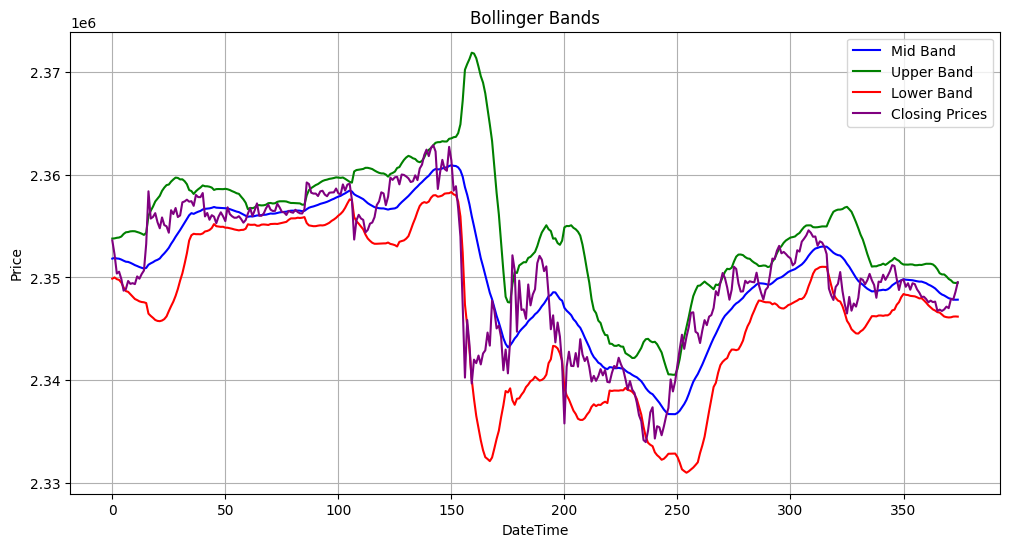

In [202]:
arima_fit_1, garch_fit_1, pred_abc, resid_pred_xyz, vol_abc = forecast_returns_percent(df, steps=375, k = 2, startdate = "2024-12-31", end_date = "2025-02-01 09:00")

upper_band = np.array(pred_abc) + 2 * np.array(vol_abc)
lower_band = np.array(pred_abc) - 2 * np.array(vol_abc)
midband = np.array(pred_abc)
# plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(midband, label='Predicted Returns Percent', color='blue')
plt.plot(upper_band, label='Upper Band', color='green')
plt.plot(lower_band, label='Lower Band', color='red')
# plt.plot(resid_pred_xyz, label='Residuals of Predicted Returns Percent', color='orange')
plt.plot(np.array(df['close_diff_percent'].loc['2025-02-01 09:00' : '2025-02-02 00:00']), label='Original Data', color='purple')
plt.title('Predicted Returns Percent')
plt.xlabel('DateTime')
plt.ylabel('Returns Percent')
plt.legend()
plt.grid()
plt.show()
# plot the bolinger bands for the same day

plt.figure(figsize=(12, 6))
plt.plot(np.array(df['close_moving_avg'].loc['2025-02-01 09:00' : '2025-02-02 00:00']), label='Mid Band', color='blue')
plt.plot(np.array(df['upper_bb'].loc['2025-02-01 09:00' : '2025-02-02 00:00']), label='Upper Band', color='green')
plt.plot(np.array(df['lower_bb'].loc['2025-02-01 09:00' : '2025-02-02 00:00']), label='Lower Band', color='red')
plt.plot(np.array(df['close'].loc['2025-02-01 09:00' : '2025-02-02 00:00']), label='Closing Prices', color='purple')
plt.title('Bollinger Bands')
plt.xlabel('DateTime')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()


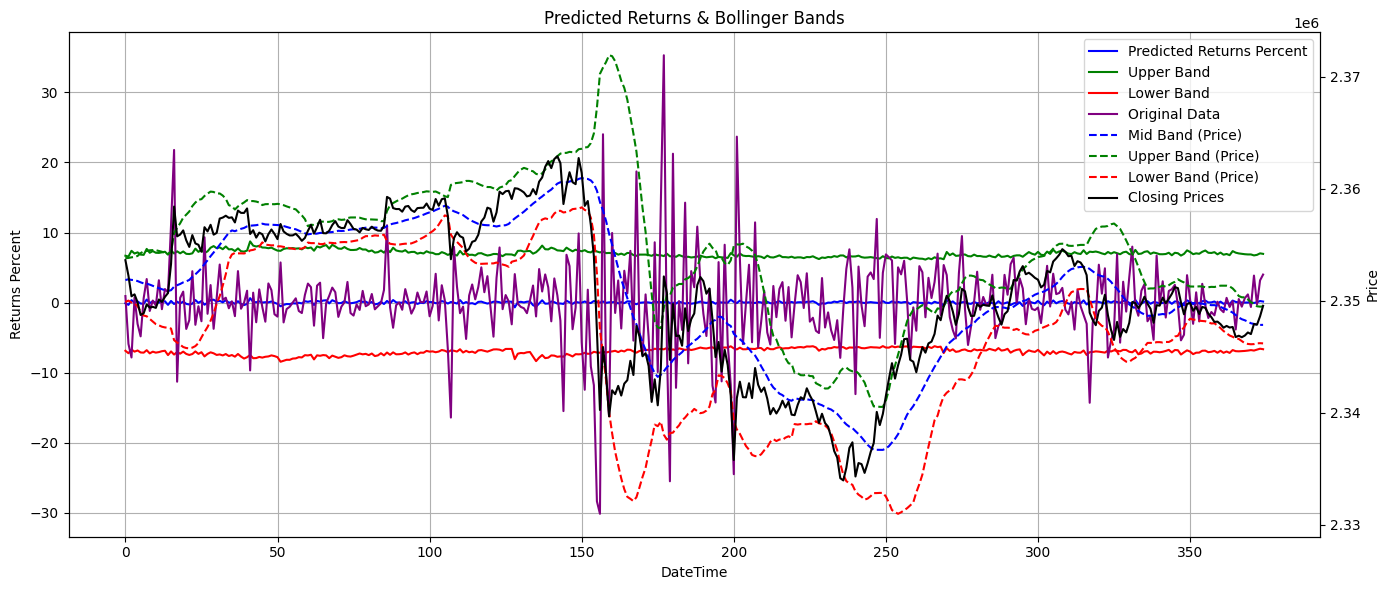

In [188]:
fig, ax1 = plt.subplots(figsize=(14, 6))

# === Left y-axis: Predicted Returns Percent ===
ax1.plot(midband, label='Predicted Returns Percent', color='blue')
ax1.plot(upper_band, label='Upper Band', color='green')
ax1.plot(lower_band, label='Lower Band', color='red')
ax1.plot(np.array(df['close_diff_percent'].loc['2025-02-01' : '2025-02-02 00:00']), label='Original Data', color='purple')
ax1.set_ylabel('Returns Percent')
ax1.set_xlabel('DateTime')
ax1.tick_params(axis='y')
ax1.legend(loc='upper left')
ax1.grid()

# === Right y-axis: Bollinger Bands and Price ===
ax2 = ax1.twinx()
ax2.plot(np.array(df['close_moving_avg'].loc['2025-02-01' : '2025-02-02 00:00']), label='Mid Band (Price)', color='blue', linestyle='--')
ax2.plot(np.array(df['upper_bb'].loc['2025-02-01' : '2025-02-02 00:00']), label='Upper Band (Price)', color='green', linestyle='--')
ax2.plot(np.array(df['lower_bb'].loc['2025-02-01' : '2025-02-02 00:00']), label='Lower Band (Price)', color='red', linestyle='--')
ax2.plot(np.array(df['close'].loc['2025-02-01' : '2025-02-02 00:00']), label='Closing Prices', color='black')
ax2.set_ylabel('Price')
ax2.tick_params(axis='y')

# === Combine legends from both axes ===
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.title('Predicted Returns & Bollinger Bands')
plt.tight_layout()
plt.show()


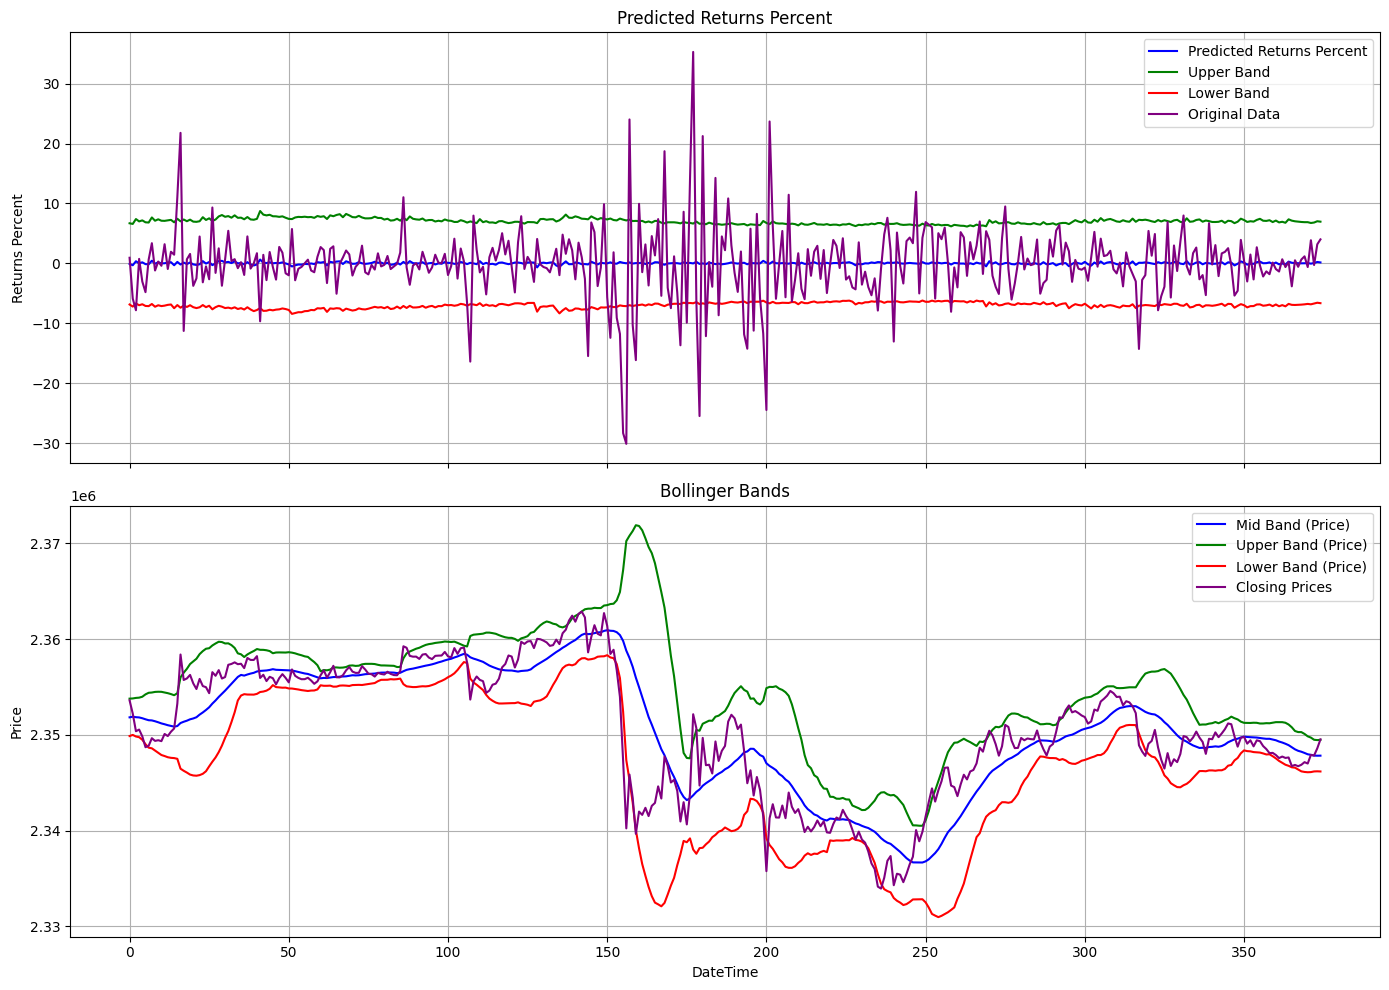

In [189]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [1, 1]})

# === Top plot: Predicted Returns Percent ===
ax1.plot(midband, label='Predicted Returns Percent', color='blue')
ax1.plot(upper_band, label='Upper Band', color='green')
ax1.plot(lower_band, label='Lower Band', color='red')
ax1.plot(np.array(df['close_diff_percent'].loc['2025-02-01' : '2025-02-02 00:00']), label='Original Data', color='purple')
ax1.set_ylabel('Returns Percent')
ax1.set_title('Predicted Returns Percent')
ax1.legend()
ax1.grid()

# === Bottom plot: Bollinger Bands and Prices ===
ax2.plot(np.array(df['close_moving_avg'].loc['2025-02-01' : '2025-02-02 00:00']), label='Mid Band (Price)', color='blue')
ax2.plot(np.array(df['upper_bb'].loc['2025-02-01' : '2025-02-02 00:00']), label='Upper Band (Price)', color='green')
ax2.plot(np.array(df['lower_bb'].loc['2025-02-01' : '2025-02-02 00:00']), label='Lower Band (Price)', color='red')
ax2.plot(np.array(df['close'].loc['2025-02-01' : '2025-02-02 00:00']), label='Closing Prices', color='purple')
ax2.set_ylabel('Price')
ax2.set_title('Bollinger Bands')
ax2.legend()
ax2.grid()

# === Common x-label ===
plt.xlabel('DateTime')
plt.tight_layout()
plt.show()


In [ ]:
# print(arima_fit_1.summary())
# print(garch_fit_1.summary())
# plot the pred_Abc
# plt.figure(figsize=(12, 6))
# plt.plot(pred_abc, label='Predicted Returns Percent', color='blue')
# plt.plot(resid_pred_xyz, label='Residuals of Predicted Returns Percent', color='orange')
# plt.title('Predicted Returns Percent')
# plt.xlabel('DateTime')
# plt.ylabel('Returns Percent')
# plt.legend()
# plt.grid()
# plt.show()
# print(arima_fit_1.forecast(steps=2))
# print(pred_abc[2])

In [108]:
df_filtered_dummy = df.loc["2024-12-31" : "2025-01-31"]
# save the df_filtered_dummy to a csv file

df_filtered_dummy.to_csv('/home/vishi/bolinger/temp_filtered_dummy.csv', index=True)
# tkes both start date and end date


In [111]:
np.array(arima_fit_1.resid)[-1]

np.float64(-1.4517310363197602)

In [128]:
np.array(garch_fit_1.params)

array([-0.00614687,  0.32839825,  0.02051696,  0.96029904])

In [129]:
garch_fit_1.params

mu         -0.006147
omega       0.328398
alpha[1]    0.020517
beta[1]     0.960299
Name: params, dtype: float64

In [137]:
# garch_volatility =
garch_fit_1.conditional_volatility

DateTime
2024-12-31 09:17:00    4.588279
2024-12-31 09:18:00    4.557498
2024-12-31 09:19:00    4.513332
2024-12-31 09:20:00    4.552311
2024-12-31 09:21:00    4.580713
                         ...   
2025-01-31 15:26:00    3.402612
2025-01-31 15:27:00    3.385017
2025-01-31 15:28:00    3.368741
2025-01-31 15:29:00    3.393769
2025-01-31 15:30:00    3.397950
Name: cond_vol, Length: 8999, dtype: float64